In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats
import numpy as np
import seaborn as sns 
from scipy.stats import ttest_ind, pearsonr, spearmanr, mannwhitneyu
import statsmodels.stats.proportion as proportion

In [2]:
df_data = pd.read_excel('New_dataset.xlsx', sheet_name='Data')
df_clients = pd.read_excel('New_dataset.xlsx', sheet_name = 'Clients')
df_region = pd.read_excel('New_dataset.xlsx', sheet_name = 'Region_dict')

df_data = df_data[~((df_data['id_client'].isnull()) | (df_data['amt_payment'].isnull()) | (df_data['dtime_pay'].isnull()))]

In [3]:
merged_df = df_data.merge(df_clients, on = 'id_client', how = 'outer')
merged_df = merged_df.merge(df_region, on = 'id_trading_point')

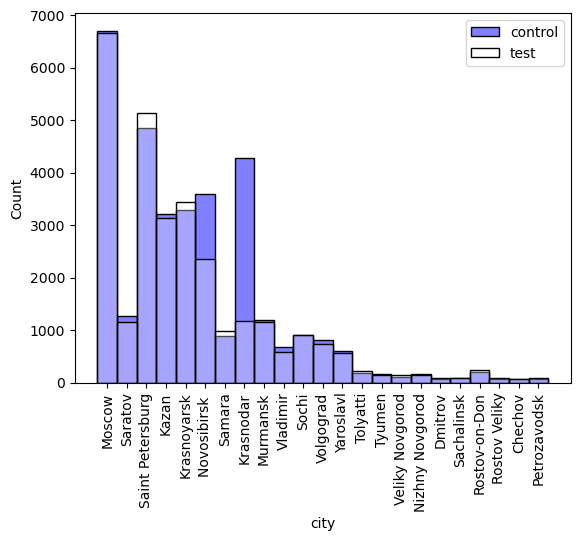

In [4]:

sns.histplot(merged_df[merged_df['nflag_test'] == 0]['city'], color='blue', alpha=0.5, label='control')
sns.histplot(merged_df[merged_df['nflag_test'] == 1]['city'], color='white', alpha=0.3, label='test')

plt.xticks(rotation=90)
plt.legend()
plt.show()


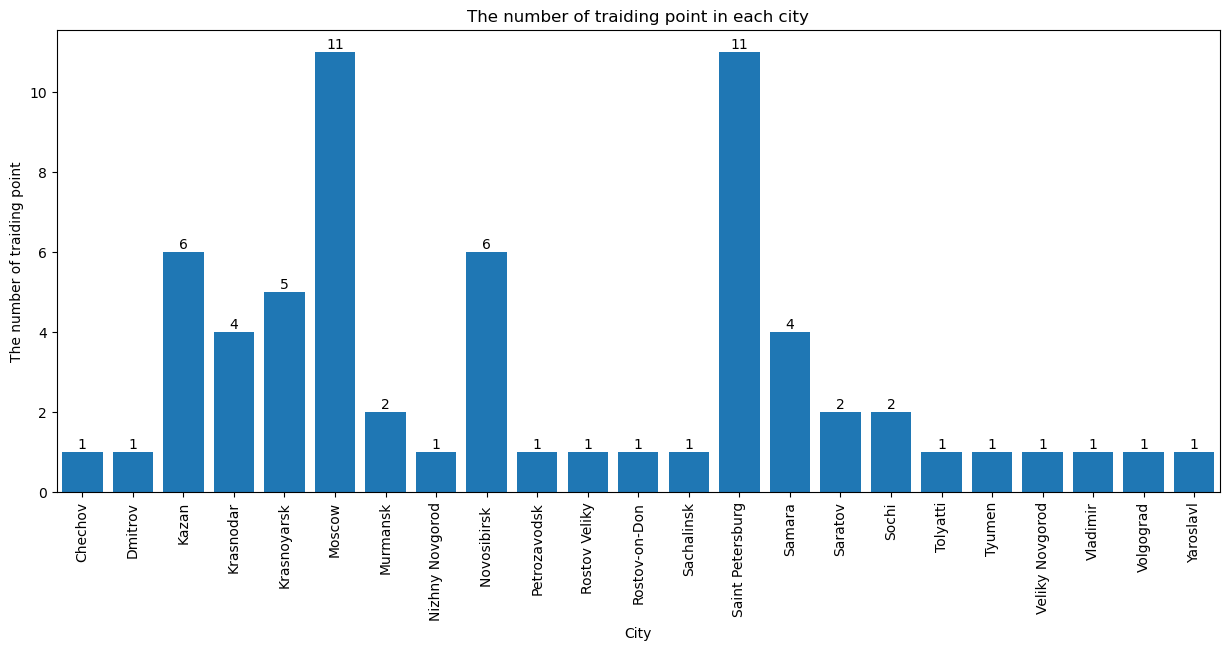

In [5]:
points_cnt = merged_df.groupby('city')['id_trading_point'].nunique()

plt.figure(figsize=(15, 6))
points_cnt.plot(kind='bar', color='orange')
plt.xlabel('City',)
plt.ylabel('The number of traiding point')
plt.title('The number of traiding point in each city')

cities = points_cnt.index
x = range(len(cities))
plt.bar(x, points_cnt, tick_label=cities, align='center')

for i, count in enumerate(points_cnt):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=90)  
plt.show()

In [6]:
payment_aggregation = df_data.groupby('id_client')['amt_payment'].sum().reset_index()

In [7]:
merged_df['amt_payment'].fillna(0, inplace=True)
df_cl = merged_df.groupby(['id_client','id_trading_point','city']).agg({'id_order':'count', 'amt_payment':'sum'}).reset_index()
df_fin = df_cl.merge(df_clients[['id_client','dtime_ad','nflag_test']], on = 'id_client')

In [8]:
df_fin['payment_flag'] = np.where(df_fin['amt_payment'] > 0, 1, 0)

In [9]:
empty_trading_points = []

for i in df_fin['id_trading_point'].unique():
    
    df_loc = df_fin[df_fin['id_trading_point']==i]
    sum_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)]['amt_payment'].sum()
    sum_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)]['amt_payment'].sum()
    if (sum_a == 0) or (sum_b == 0):
        empty_trading_points.append(i)
        
print(empty_trading_points)

[26, 739, 866, 46, 1099, 1015, 603, 810, 800, 228, 4, 1, 7]


In [10]:
empty_control_or_test_points = []

for i in df_fin['id_trading_point'].unique():
    
    c_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].count()['id_client']
    c_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].count()['id_client']
    if (c_a == 0) | (c_b == 0):
        empty_control_or_test_points.append(i)
        
print(empty_control_or_test_points)

[739, 866, 1099, 1015, 603, 810, 800, 228]


In [11]:
df_merged_point_city = df_fin[~df_fin['id_trading_point'].isin(empty_control_or_test_points + empty_trading_points)]

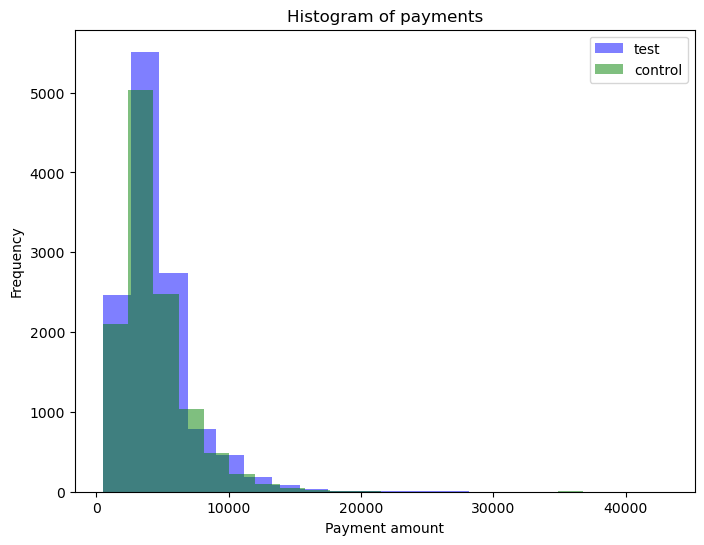

In [12]:
plt.figure(figsize=(8,6))
plt.xlabel('Payment amount')
plt.ylabel('Frequency')
plt.title('Histogram of payments')

test = df_merged_point_city[(df_merged_point_city['nflag_test'] == 1) & (df_merged_point_city['amt_payment'] > 0)]['amt_payment']
control = df_merged_point_city[(df_merged_point_city['nflag_test'] == 0) & (df_merged_point_city['amt_payment'] > 0)]['amt_payment']

plt.hist(test, bins=20, alpha=0.5, color='blue', label='test')
plt.hist(control, bins=20, alpha=0.5, color='green', label='control')

plt.legend(loc='upper right')
plt.show()

In [13]:
def test_calc(r1, r2, alpha = 0.05):
    
    s,p = ttest_ind(r1,r2)
    
    if p < alpha:
        print('Hypothesis H0 is NOT confirmed: the means are not equal')
    else:
        print('Hypothesis H0 is confirmed: the means are equal')
    
    print('Mean value of 1st row', r1.mean())
    print('Mean value of 2nd row', r2.mean())
    print('Mean difference = ', r1.mean()-r2.mean())
    print('P_value =',p)
    return s, p

In [14]:
def test_calc_conv(r1, r2, alpha = 0.05):
    
    s,p = ttest_ind(r1,r2)
    
    if p < alpha:
         print('There is a statistically significant difference between conversions (p-value < {:.2f})'.format(alpha))
    else:
        print('There is NO statistically significant difference between conversions (p-value >= {:.2f})'.format(alpha))
            
    print('Mean value of 1st row', r1.mean())
    print('Mean value of 2nd row', r2.mean())
    print('Mean difference = ', r1.mean()-r2.mean())
    print('P_value =',p)
    return s, p

In [63]:
def mann_whitney_func(r1, r2, alpha=0.05):
    
    s, p = mannwhitneyu(r1, r2)
    
    if p < alpha:
        print('The distributions are NOT equal')
    else:
        print('The distributions are equal')
    
    print('P_value =',p)
    return s, p

In [64]:
test_calc(control, test)

Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 4379.020091798736
Mean value of 2nd row 4513.450752338349
Mean difference =  -134.4306605396132
P_value = 0.00012983442156519871


(-3.8274003597445527, 0.00012983442156519871)

In [65]:
test_group = df_merged_point_city[df_merged_point_city['nflag_test'] == 1]
control_group = df_merged_point_city[df_merged_point_city['nflag_test'] == 0]

test_group_paid = test_group[test_group['payment_flag'] == 1]
control_group_paid = control_group[control_group['payment_flag'] == 1]


test_conversion = test_group_paid.agg({'id_client': 'count'})
total_test = test_group.agg({'id_client': 'count'})
test_conversion['conv'] = round(test_conversion['id_client'] / total_test['id_client'] * 100, 2)
print(test_conversion[1])

control_conversion = control_group_paid.agg({'id_client': 'count'})
total_control = control_group.agg({'id_client': 'count'})
control_conversion['conv'] = round(control_conversion['id_client'] / total_control['id_client'] * 100, 2)
print(control_conversion[1])

54.14
49.92


In [66]:
test_calc_conv(control_conversion,test_conversion)

There is NO statistically significant difference between conversions (p-value >= 0.05)
Mean value of 1st row 5798.46
Mean value of 2nd row 6174.57
Mean difference =  -376.1099999999997
P_value = 0.9683429064339191


(-0.0447923414983418, 0.9683429064339191)

In [67]:
from termcolor import colored

In [68]:
print(colored('CONCLUSION: No statistically significant difference in conversion was found as the p-value is above the selected threshold of first-order error', attrs=['bold']))

CONCLUSION: No statistically significant difference in conversion was found as the p-value is above the selected threshold of first-order error


In [69]:
mann_whitney_func(control, test)

The distributions are NOT equal
P_value = 2.661546983876045e-05


(68754155.5, 2.661546983876045e-05)

In [70]:
print(colored('CONCLUSION: Thus, there is a statistically significant difference between the considered distributions of samples r1 and r2, as the value (p_value) turned out to be very small, which is much less than the significance level alpha (0.05). Therefore, the null hypothesis is rejected, according to which the distributions of r1 and r2 are equal.', 'black', attrs=['bold']))

CONCLUSION: Thus, there is a statistically significant difference between the considered distributions of samples r1 and r2, as the value (p_value) turned out to be very small, which is much less than the significance level alpha (0.05). Therefore, the null hypothesis is rejected, according to which the distributions of r1 and r2 are equal.


In [71]:
msk = df_merged_point_city[df_merged_point_city['city']=='Moscow']

In [72]:
test_msk = msk[msk['nflag_test'] == 1]['amt_payment']
control_msk = msk[msk['nflag_test'] == 0]['amt_payment']

In [73]:
test_calc(control_msk, test_msk,alpha = 0.05)

Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 1986.18059125964
Mean value of 2nd row 2367.9590805347243
Mean difference =  -381.7784892750842
P_value = 1.757549439555765e-14


(-7.676511027843395, 1.757549439555765e-14)

In [74]:
test_gr_msk = msk[msk['nflag_test'] == 1]
control_gr_msk = msk[msk['nflag_test'] == 0]

test_gr_paid_msk = test_gr_msk[test_gr_msk['payment_flag'] == 1]
control_gr_paid_msk = control_gr_msk[control_gr_msk['payment_flag'] == 1]


test_conversion_msk = test_gr_paid_msk.agg({'id_client': 'count'})
total_test_msk = test_msk.agg({'id_client': 'count'})
test_conversion_msk['conv'] = round(test_conversion_msk['id_client'] / total_test_msk['id_client'] * 100, 2)
print(test_conversion_msk)

control_conversion_msk = control_gr_paid_msk.agg({'id_client': 'count'})
total_control_msk = control_msk.agg({'id_client': 'count'})
control_conversion_msk['conv'] = round(control_conversion_msk['id_client'] / total_control_msk['id_client'] * 100, 2)
print(control_conversion_msk)

id_client    3334.00
conv           54.35
dtype: float64
id_client    3037.00
conv           48.79
dtype: float64


In [75]:
test_calc_conv(control_conversion_msk, test_conversion_msk,alpha = 0.05)

There is NO statistically significant difference between conversions (p-value >= 0.05)
Mean value of 1st row 1542.895
Mean value of 2nd row 1694.175
Mean difference =  -151.27999999999997
P_value = 0.9518363994925305


(-0.06819275744808795, 0.9518363994925305)

In [76]:
print(colored('CONCLUSION: There is no statistically significant difference between conversions, in the city of Moscow, as the p-value is greater than 0.05', 'black', attrs=['bold']))

CONCLUSION: There is no statistically significant difference between conversions, in the city of Moscow, as the p-value is greater than 0.05


In [77]:
mann_whitney_func(control_msk, test_msk)

The distributions are NOT equal
P_value = 7.010591402203484e-16


(17582441.5, 7.010591402203484e-16)

In [78]:
print(colored('CONCLUSION: the distributions of the two samples (for the control and test group in the city of Moscow) are not equal because the significance level (p-value) is very low and less than the specified threshold (alpha = 0.05), indicating a statistically significant difference between the samples.', 'black', attrs=['bold']))

CONCLUSION: the distributions of the two samples (for the control and test group in the city of Moscow) are not equal because the significance level (p-value) is very low and less than the specified threshold (alpha = 0.05), indicating a statistically significant difference between the samples.


In [79]:
spb = df_merged_point_city[df_merged_point_city['city']=='Saint Petersburg']

In [80]:
test_spb = spb[spb['nflag_test'] == 1]['amt_payment']
control_spb = spb[spb['nflag_test'] == 0]['amt_payment']

In [81]:
test_calc(control_spb, test_spb, alpha = 0.05)

Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 1913.5586377988272
Mean value of 2nd row 2427.462542182227
Mean difference =  -513.9039043833998
P_value = 2.3198088937974163e-18


(-8.759635784179547, 2.3198088937974163e-18)

In [82]:
test_gr_spb = spb[spb['nflag_test'] == 1]
control_gr_spb = spb[spb['nflag_test'] == 0]

test_gr_paid_spb = test_gr_spb[test_gr_spb['payment_flag'] == 1]
control_gr_paid_spb = control_gr_spb[control_gr_spb['payment_flag'] == 1]

test_conversion_spb = test_gr_paid_spb.agg({'id_client': 'count'})
total_test_spb = test_spb.agg({'id_client': 'count'})
test_conversion_spb['conv'] = round(test_conversion_spb['id_client'] / total_test_spb['id_client'] * 100, 2)
print(test_conversion_spb)

control_conversion_spb = control_gr_paid_spb.agg({'id_client': 'count'})
total_control_spb = control_spb.agg({'id_client': 'count'})
control_conversion_spb['conv'] = round(control_conversion_spb['id_client'] / total_control_spb['id_client'] * 100, 2)
print(control_conversion_spb)

id_client    2432.00
conv           54.71
dtype: float64
id_client    1988.00
conv           44.84
dtype: float64


In [83]:
test_calc_conv(control_conversion_spb, test_conversion_spb, alpha = 0.05)

There is NO statistically significant difference between conversions (p-value >= 0.05)
Mean value of 1st row 1016.42
Mean value of 2nd row 1243.355
Mean difference =  -226.93500000000006
P_value = 0.8960411593448101


(-0.14782095541893348, 0.8960411593448101)

In [84]:
print(colored('CONCLUSION: There is no statistically significant difference between conversions, in the city of St. Petersburg, as the p-value is greater than 0.05', 'black', attrs=['bold']))

CONCLUSION: There is no statistically significant difference between conversions, in the city of St. Petersburg, as the p-value is greater than 0.05


In [85]:
mann_whitney_func(control_spb, test_spb)

The distributions are NOT equal
P_value = 2.0392184217953754e-20


(8809444.5, 2.0392184217953754e-20)

In [86]:
print(colored('CONCLUSION: the distributions of the two samples (for the control and test group in the city of St. Petersburg) are not equal because the significance level (p-value) is very low and less than the specified threshold (alpha = 0.05), indicating a statistically significant difference between the samples.', 'black', attrs=['bold']))

CONCLUSION: the distributions of the two samples (for the control and test group in the city of St. Petersburg) are not equal because the significance level (p-value) is very low and less than the specified threshold (alpha = 0.05), indicating a statistically significant difference between the samples.


In [87]:

for city in df_merged_point_city['city'].unique():
    if city not in ('Moscow', 'Saint Petersburg'):
        print(city)
        
        control_group = df_merged_point_city[(df_merged_point_city['nflag_test'] == 0) &
                                             (df_merged_point_city['city'] == city)]['amt_payment']
        test_group = df_merged_point_city[(df_merged_point_city['nflag_test'] == 1) &
                                          (df_merged_point_city['city'] == city)]['amt_payment']

        test_calc(control_group, test_group)


Saratov
Hypothesis H0 is confirmed: the means are equal
Mean value of 1st row 2541.6456266907126
Mean value of 2nd row 2528.7887462981244
Mean difference =  12.85688039258821
P_value = 0.9162512798549167
Tolyatti
Hypothesis H0 is confirmed: the means are equal
Mean value of 1st row 2439.4610778443116
Mean value of 2nd row 2902.4105263157894
Mean difference =  -462.9494484714778
P_value = 0.1333273246710206
Vladimir
Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 2108.6101973684213
Mean value of 2nd row 2547.2200392927307
Mean difference =  -438.6098419243094
P_value = 0.010095112170351712
Murmansk
Hypothesis H0 is confirmed: the means are equal
Mean value of 1st row 1857.2197183098592
Mean value of 2nd row 1865.2710900473933
Mean difference =  -8.051371737534055
P_value = 0.9449762446327565
Krasnoyarsk
Hypothesis H0 is confirmed: the means are equal
Mean value of 1st row 2428.7775862068966
Mean value of 2nd row 2437.4958840961476
Mean difference =  -8.7182

In [88]:
for city in df_merged_point_city['city'].unique():
    if city not in ('Moscow', 'Saint Petersburg'):
        print(city)   
        
        control_group_city = df_merged_point_city[(df_merged_point_city['nflag_test'] == 0) &
                                                  (df_merged_point_city['city'] == city)]
        control_gr_paid_city = control_group_city[control_group_city['payment_flag'] == 1]
        
        control_conversion_city = control_gr_paid_city.agg({'id_client': 'count'})
        total_control_city = control_group.agg({'id_client': 'count'})
        
        control_conversion_city['conv'] = round(control_conversion_city['id_client'] / total_control_city['id_client'] * 100, 2)
                                                  
        
        test_group_city = df_merged_point_city[(df_merged_point_city['nflag_test'] == 1) &
                                                  (df_merged_point_city['city'] == city)]
        test_gr_paid_city = test_group_city[test_group_city['payment_flag'] == 1]
        
        test_conversion_city = test_gr_paid_city.agg({'id_client': 'count'})
        total_test_city = test_group.agg({'id_client': 'count'})
        test_conversion_city['conv'] = round(test_conversion_city['id_client'] / total_test_city['id_client'] * 100, 2)
        
        test_calc_conv(control_conversion_city, test_conversion_city, alpha = 0.05)

Saratov
There is NO statistically significant difference between conversions (p-value >= 0.05)
Mean value of 1st row 726.835
Mean value of 2nd row 695.335
Mean difference =  31.5
P_value = 0.8359459305622399
Tolyatti
There is NO statistically significant difference between conversions (p-value >= 0.05)
Mean value of 1st row 110.68
Mean value of 2nd row 142.33499999999998
Mean difference =  -31.654999999999973
P_value = 0.3256261166341925
Vladimir
There is NO statistically significant difference between conversions (p-value >= 0.05)
Mean value of 1st row 345.73
Mean value of 2nd row 326.66499999999996
Mean difference =  19.065000000000055
P_value = 0.7916166245752192
Murmansk
There is NO statistically significant difference between conversions (p-value >= 0.05)
Mean value of 1st row 508.895
Mean value of 2nd row 537.835
Mean difference =  -28.940000000000055
P_value = 0.798151353835056
Krasnoyarsk
There is NO statistically significant difference between conversions (p-value >= 0.05)
Mea

In [89]:
print(colored('CONCLUSION: Based on the findings, it can be concluded that there is no statistically significant difference between conversions in all cities as the p-value in each case is greater than the significance level of 0.05.', 'black', attrs=['bold']))

CONCLUSION: Based on the findings, it can be concluded that there is no statistically significant difference between conversions in all cities as the p-value in each case is greater than the significance level of 0.05.


In [90]:
for city in df_merged_point_city['city'].unique():
    if city not in ('Москва', 'Санкт-Петербург'):
        print(city)
        
        control_group = df_merged_point_city[(df_merged_point_city['nflag_test'] == 0) &
                                             (df_merged_point_city['city'] == city)]['amt_payment']
        test_group = df_merged_point_city[(df_merged_point_city['nflag_test'] == 1) &
                                          (df_merged_point_city['city'] == city)]['amt_payment']

        mann_whitney_func(control_group, test_group)

Saint Petersburg
The distributions are NOT equal
P_value = 2.0392184217953754e-20
Moscow
The distributions are NOT equal
P_value = 7.010591402203484e-16
Saratov
The distributions are equal
P_value = 0.7833257779753139
Tolyatti
The distributions are equal
P_value = 0.22134177144014489
Vladimir
The distributions are NOT equal
P_value = 0.03166761411886426
Murmansk
The distributions are equal
P_value = 0.5434251528583327
Krasnoyarsk
The distributions are equal
P_value = 0.8770469886251647
Kazan
The distributions are equal
P_value = 0.37726004167062477
Samara
The distributions are NOT equal
P_value = 4.325201867794148e-30
Volgograd
The distributions are NOT equal
P_value = 0.03323940159324537
Sochi
The distributions are equal
P_value = 0.05698257474271896
Krasnodar
The distributions are equal
P_value = 0.05938101983441801
Dmitrov
The distributions are equal
P_value = 0.7422551789442879
Nizhny Novgorod
The distributions are equal
P_value = 0.16861458593517797
Veliky Novgorod
The distributio

In [91]:
print(colored('CONCLUSION: In the cities of Krasnoyarsk, Murmansk, Kazan, Saratov, Togliatti, Sochi and Dmitrov the p-value is above the significance level of 0.05, therefore the null hypothesis of equality of distributions in groups can NOT be rejected. For the cities of Yaroslavl, Tyumen, Volgograd, Vladimir and Samara - p-value is less than 0.05, therefore the null hypothesis about equality of distributions in groups can be rejected.  Thus, in the control and test groups differences were found for the cities of Yaroslavl, Tyumen, Volgograd, Vladimir and Samara. For the cities of Krasnoyarsk, Murmansk, Kazan, Saratov, Togliatti, Sochi and Dmitrov, no differences between groups were found based on the Mann-Whitney test.', 'black', attrs=['bold']))

CONCLUSION: In the cities of Krasnoyarsk, Murmansk, Kazan, Saratov, Togliatti, Sochi and Dmitrov the p-value is above the significance level of 0.05, therefore the null hypothesis of equality of distributions in groups can NOT be rejected. For the cities of Yaroslavl, Tyumen, Volgograd, Vladimir and Samara - p-value is less than 0.05, therefore the null hypothesis about equality of distributions in groups can be rejected.  Thus, in the control and test groups differences were found for the cities of Yaroslavl, Tyumen, Volgograd, Vladimir and Samara. For the cities of Krasnoyarsk, Murmansk, Kazan, Saratov, Togliatti, Sochi and Dmitrov, no differences between groups were found based on the Mann-Whitney test.


In [92]:
df_merged_point_city

,id_client,id_trading_point,city,id_order,amt_payment,dtime_ad,nflag_test,payment_flag
0,178561.0,453,Saint Petersburg,1,3052.0,2022-06-03 02:47:49.183,0,1
1,178562.0,2652,Moscow,1,2439.0,2022-06-03 02:51:21.878,0,1
2,178563.0,112,Saint Petersburg,1,768.0,2022-06-03 02:52:10.616,1,1
6,178567.0,453,Saint Petersburg,1,2663.0,2022-06-03 03:02:56.855,0,1
7,178568.0,3786,Moscow,3,13537.0,2022-06-03 03:05:33.476,1,1
...,...,...,...,...,...,...,...,...
55600,331949.0,573,Saint Petersburg,0,0.0,2022-07-15 10:07:09.632,1,0
55601,331950.0,1654,Moscow,0,0.0,2022-07-18 03:10:18.517,1,0
55602,331954.0,544,Kazan,0,0.0,2022-07-08 12:45:17.300,0,0
55603,331955.0,72,Sochi,0,0.0,2022-08-12 03:15:49.011,0,0


In [93]:
data = df_merged_point_city[((df_merged_point_city['nflag_test'] == 1) & (df_merged_point_city['amt_payment'] > 0) & (df_merged_point_city['id_client'] > 0)) |
                            ((df_merged_point_city['nflag_test'] == 0) & (df_merged_point_city['amt_payment'] > 0) & (df_merged_point_city['id_client'] > 0))]
# print(data.info())

In [94]:
result_df = pd.DataFrame()

for i in df_fin['city'].unique():
    df_loc = df_merged_point_city[df_merged_point_city['city']==i]
    
    for j in df_loc['id_trading_point'].unique():
        
        df_loc_f      = df_loc[df_loc['id_trading_point']==j]
        
        count_test    = len(df_loc_f[df_loc_f['nflag_test']==1])
        count_control = len(df_loc_f[df_loc_f['nflag_test']==0])
        count_all     = count_test + count_control
        sigma_test    = df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'].std()
        sigma_control = df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'].std()
        
        avg_test    = np.mean(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'])
        avg_control = np.mean(df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        diff        = avg_test - avg_control
        
        s_a,p_a  = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        s_p,p_p  = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['payment_flag'], df_loc_f[df_loc_f['nflag_test']==0]['payment_flag'])
        m_s, m_p = mann_whitney_func(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])

        result_df = result_df = pd.concat([result_df, pd.DataFrame({'city': [i], 'id_trading_point': [j],
                                                                    'count_test': [count_test], 'count_control': [count_control], 'count_all': [count_all],
                                                                    'avg_test': [avg_test], 'avg_control': [avg_control],
                                                                    'sigma_test': [sigma_test], 'sigma_control': [sigma_control],
                                                                    'diff': [diff], 'abs_ttest_s': [s_a], 'abs_ttest_p': [p_a], 'pr_ttest_s': [s_p]})], ignore_index=True)     

            
result_df['label'] = np.where((result_df['abs_ttest_p'] < .05) & (result_df['diff'] > 0), 'positive'
                                , np.where((result_df['abs_ttest_p'] < .05) & (result_df['diff'] < 0), 'negative', 'neutral'))
result_df['percent_count'] = (result_df['count_all'] / result_df['count_all'].sum())

Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 2501.966228893058
Mean value of 2nd row 1889.9237368922784
Mean difference =  612.0424920007797
P_value = 6.983206901274464e-07
Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 0.5562851782363978
Mean value of 2nd row 0.43660629170638704
Mean difference =  0.11967888653001074
P_value = 3.381305634110329e-08
The distributions are NOT equal
P_value = 1.8091938713109172e-07
Hypothesis H0 is confirmed: the means are equal
Mean value of 1st row 2488.115030674847
Mean value of 2nd row 2218.636896046852
Mean difference =  269.4781346279947
P_value = 0.07683710303752554
Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 0.5766871165644172
Mean value of 2nd row 0.5168374816983895
Mean difference =  0.05984963486602768
P_value = 0.0281319517757112
The distributions are NOT equal
P_value = 0.045325599351465
Hypothesis H0 is NOT confirmed: the means are not equal
Me

The distributions are equal
P_value = 0.8637165123146039
Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 4121.753623188406
Mean value of 2nd row 1844.787234042553
Mean difference =  2276.966389145853
P_value = 1.1223868363766535e-09
Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 0.6811594202898551
Mean value of 2nd row 0.44680851063829785
Mean difference =  0.23435090965155725
P_value = 2.2229287062995777e-05
The distributions are NOT equal
P_value = 2.075765659611164e-09
Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 1415.7843137254902
Mean value of 2nd row 1968.6934306569342
Mean difference =  -552.909116931444
P_value = 0.034929468998951815
Hypothesis H0 is NOT confirmed: the means are not equal
Mean value of 1st row 0.35947712418300654
Mean value of 2nd row 0.5182481751824818
Mean difference =  -0.15877105099947525
P_value = 0.006353519667404301
The distributions are NOT equal
P_value = 0.02

Hypothesis H0 is confirmed: the means are equal
Mean value of 1st row 1171.4533333333334
Mean value of 2nd row 600.1538461538462
Mean difference =  571.2994871794872
P_value = 0.105809212549273
Hypothesis H0 is confirmed: the means are equal
Mean value of 1st row 0.21333333333333335
Mean value of 2nd row 0.14102564102564102
Mean difference =  0.07230769230769232
P_value = 0.2436724740693643
The distributions are equal
P_value = 0.19868569514015844


In [95]:
writer = pd.ExcelWriter('AB_test_results.xlsx', engine='xlsxwriter')
result_df[result_df['label'] == 'positive'].to_excel(writer, sheet_name='Positive', index=False)
result_df[result_df['label'] == 'negative'].to_excel(writer, sheet_name='Negative', index=False)
result_df[result_df['label'] == 'neutral'].to_excel(writer, sheet_name='Neutral', index=False)

writer.close()

In [96]:
result_df[result_df['label'] == 'negative']

,city,id_trading_point,count_test,count_control,count_all,avg_test,avg_control,sigma_test,sigma_control,diff,abs_ttest_s,abs_ttest_p,pr_ttest_s,label,percent_count
21,Moscow,9931,153,137,290,1415.784314,1968.693431,2038.164247,2403.397857,-552.909117,-2.119197,0.034929,-2.749104,negative,0.006326
39,Krasnodar,1101,785,869,1654,2176.003822,2523.578826,2722.624494,2960.352338,-347.575005,-2.476736,0.013358,-2.138582,negative,0.036081
45,Volgograd,66,657,703,1360,2288.870624,2601.761024,2682.567610,2830.193773,-312.890400,-2.089272,0.036869,-1.622217,negative,0.029668
